<a href="https://colab.research.google.com/github/huseyinmuldur/NaivBayesClassifier/blob/main/NaivBayesClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Veri setini yükleme ve veriyi karıştırma**

In [3]:
import numpy as np
import pandas as pd

# Veri setini yükleme
data = pd.read_csv('spam_ham_dataset.csv', encoding='ISO-8859-1', engine='python')
print(data.describe())

# Veriyi karıştırma
data = data.sample(frac=1, random_state=42).reset_index(drop=True)


        Unnamed: 0    label_num
count  5171.000000  5171.000000
mean   2585.000000     0.289886
std    1492.883452     0.453753
min       0.000000     0.000000
25%    1292.500000     0.000000
50%    2585.000000     0.000000
75%    3877.500000     1.000000
max    5170.000000     1.000000


**Veriyi eğitim ve test setlerine ayırma**

In [4]:
# Veriyi eğitim ve test setlerine ayırma oranı
train_ratio = 0.8
train_size = int(len(data) * train_ratio)

# Veriyi eğitim ve test setlerine böleme
train_data = data[:train_size]
test_data = data[train_size:]


**Eğitim ve test setlerinde ham ve spam mailleri ayırma**

In [5]:
# Ham ve spam mailleri eğitim setinde ayırma
train_ham_mails = train_data[train_data['label'] == 'ham']
train_spam_mails = train_data[train_data['label'] == 'spam']

# Ham ve spam mailleri test setinde ayırma
test_ham_mails = test_data[test_data['label'] == 'ham']
test_spam_mails = test_data[test_data['label'] == 'spam']


**Eğitim seti için olasılıkları hesaplama**

In [6]:
# Eğitim seti için ham ve spam maillerin olasılıklarını hesaplama
p_ham = len(train_ham_mails) / len(train_data)
p_spam = len(train_spam_mails) / len(train_data)


**Kelime olasılıklarını hesaplama**

In [8]:
# Kelime sayılarını hesaplama
ham_words = ' '.join(train_ham_mails['text']).split()
spam_words = ' '.join(train_spam_mails['text']).split()

# Tüm kelimelerin toplam sayısı
total_words = len(set(ham_words + spam_words))

# Kelimelerin olasılıklarını hesaplama
word_counts_ham = {word: (ham_words.count(word) + 1) / (len(ham_words) + total_words) for word in set(ham_words)}
word_counts_spam = {word: (spam_words.count(word) + 1) / (len(spam_words) + total_words) for word in set(spam_words)}


**Tahmin fonksiyonu oluşturma**

In [9]:
# Örnek veri seti üzerinden tahmin yapma
def predict(text):
    words = text.split()
    p_h_given_text = np.log(p_ham)
    p_s_given_text = np.log(p_spam)
    for word in words:
        if word in word_counts_ham:
            p_h_given_text += np.log(word_counts_ham[word])
        else:
            p_h_given_text += np.log(1 / (len(ham_words) + total_words))

        if word in word_counts_spam:
            p_s_given_text += np.log(word_counts_spam[word])
        else:
            p_s_given_text += np.log(1 / (len(spam_words) + total_words))

    if p_h_given_text > p_s_given_text:
        return 'ham'
    else:
        return 'spam'


**Test seti üzerinde tahmin yapma**

In [12]:
# Test seti üzerinde tahmin yapma
test_data = test_data.copy()  # DataFrame'in kopyasını oluşturmak için
test_data.loc[:, 'predicted'] = test_data['text'].apply(predict)



**Sonuçları değerlendirme**





In [13]:
# Confusion Matrix hesaplama
confusion_matrix = pd.crosstab(test_data['label'], test_data['predicted'], rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion Matrix:")
print(confusion_matrix)

# Accuracy, Precision, Recall ve F1 Score hesaplama
TP = confusion_matrix.loc['ham', 'ham']
FP = confusion_matrix.loc['spam', 'ham']
FN = confusion_matrix.loc['ham', 'spam']
TN = confusion_matrix.loc['spam', 'spam']

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * precision * recall / (precision + recall)

print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)



Confusion Matrix:
Predicted  ham  spam
Actual              
ham        702    18
spam         6   309

Accuracy: 0.9768115942028985
Precision: 0.9915254237288136
Recall: 0.975
F1 Score: 0.9831932773109243


**VERİ KEŞFİ**

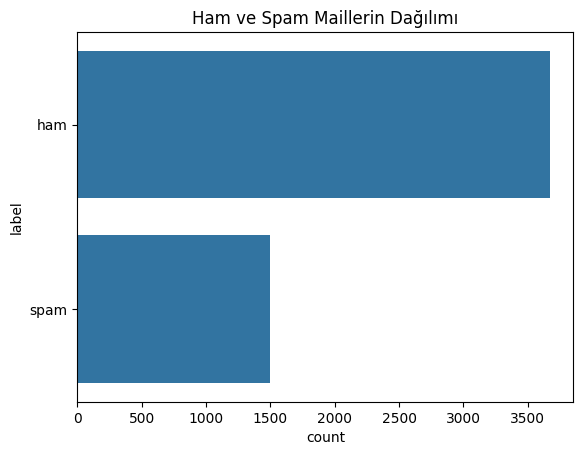

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ham ve spam maillerin dağılımı
sns.countplot(data['label'])
plt.title('Ham ve Spam Maillerin Dağılımı')
plt.show()


**KELİME BULUTLARI**

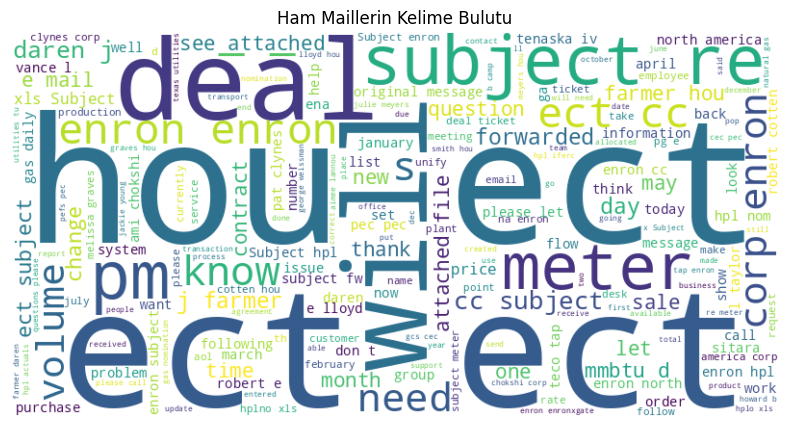

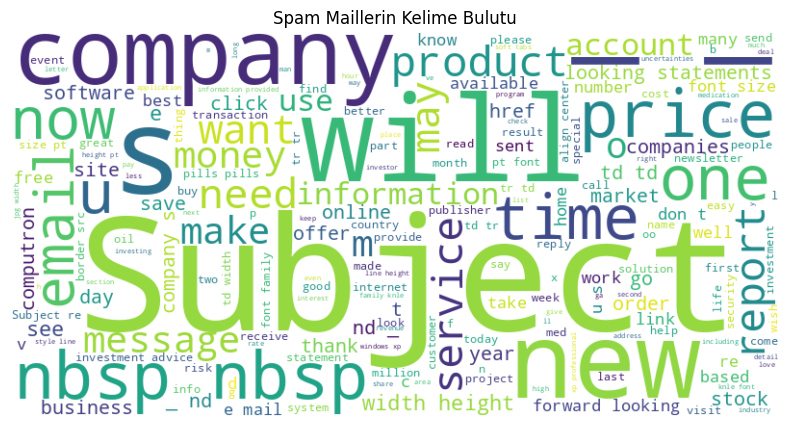

In [15]:
from wordcloud import WordCloud

# Ham maillerin kelime bulutu
ham_text = ' '.join(train_ham_mails['text'])
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)

plt.figure(figsize=(10, 5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Ham Maillerin Kelime Bulutu')
plt.axis('off')
plt.show()

# Spam maillerin kelime bulutu
spam_text = ' '.join(train_spam_mails['text'])
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Spam Maillerin Kelime Bulutu')
plt.axis('off')
plt.show()


**ROC Eğrisi ve AUC**

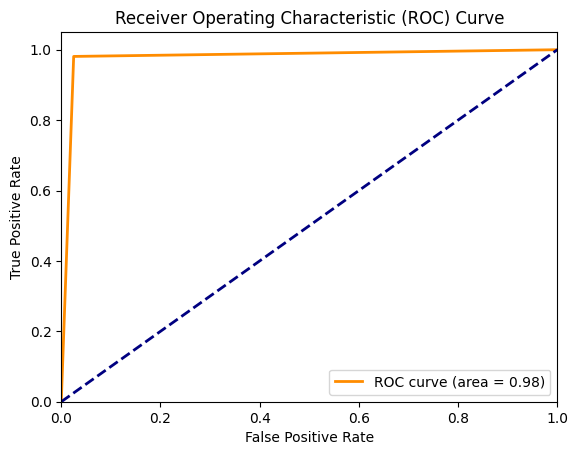

In [16]:
from sklearn.metrics import roc_curve, auc

# Tahminlerin olasılıklarını elde etme
y_true = test_data['label'].apply(lambda x: 1 if x == 'spam' else 0)
y_scores = test_data['predicted'].apply(lambda x: 1 if x == 'spam' else 0)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


**Laplace Smoothing için Farklı Parametreler**

**Diğer Modellerin Eğitilmesi ve Değerlendirilmesi**